<a href="https://colab.research.google.com/github/mrisong/GeospatialML/blob/main/CloudCoverDetectionMasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install xarray
%pip install xarray-spatial
%pip install rasterio
%pip install transformers
%pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow 2.14.0 requires numpy>=1.23.5, but you have numpy 1.23.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import xarray
import xrspatial.multispectral as ms
import matplotlib.pyplot as plt
import rasterio
import time

from typing import List
from transformers import SegformerConfig, SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.utils.prune as prune
import evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

data_dir = "/content/gdrive/My Drive/CloudCoverData/"
feature_dir = f"{data_dir}train_features/"
label_dir = f"{data_dir}train_labels/"

meta_data = pd.read_csv(f"{data_dir}train_metadata.csv")

bands = ["B02", "B03", "B04", "B08"]

Mounted at /content/gdrive


Looking at the meta data stored in some image.
We note the image size here - 512×512

In [ ]:
with rasterio.open(f"{feature_dir}jado/B02.tif") as f:
    meta = f.meta
print(meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 785045.0,
       0.0, -10.0, 8253225.0)}


In [ ]:
location_counts = meta_data.groupby("location")["chip_id"].nunique()
# location_counts

In [ ]:
def add_paths(df, feature_dir, label_dir, bands=bands):
    for band in bands:
        df[f"{band}_path"] = feature_dir + df['chip_id'] + f"/{band}.tif"
        # assert df[f"{band}_path"].path.exists().all()

    df["label_path"] = label_dir + df['chip_id'] + ".tif"

    # assert df["label_path"].path.exists().all()
    return df

meta_data = add_paths(meta_data, feature_dir, label_dir)

In [ ]:
def make_DataArray(path):
  img_array = np.array(Image.open(path))
  return xarray.DataArray(img_array, dims = ['y', 'x'])

def true_color_img(chip_id, data_path = feature_dir):
  chip_path = f"{data_path}{chip_id}/"
  red = make_DataArray(f"{chip_path}B04.tif")
  green = make_DataArray(f"{chip_path}B03.tif")
  blue = make_DataArray(f"{chip_path}B02.tif")
  return ms.true_color(r=red, g=green, b=blue)

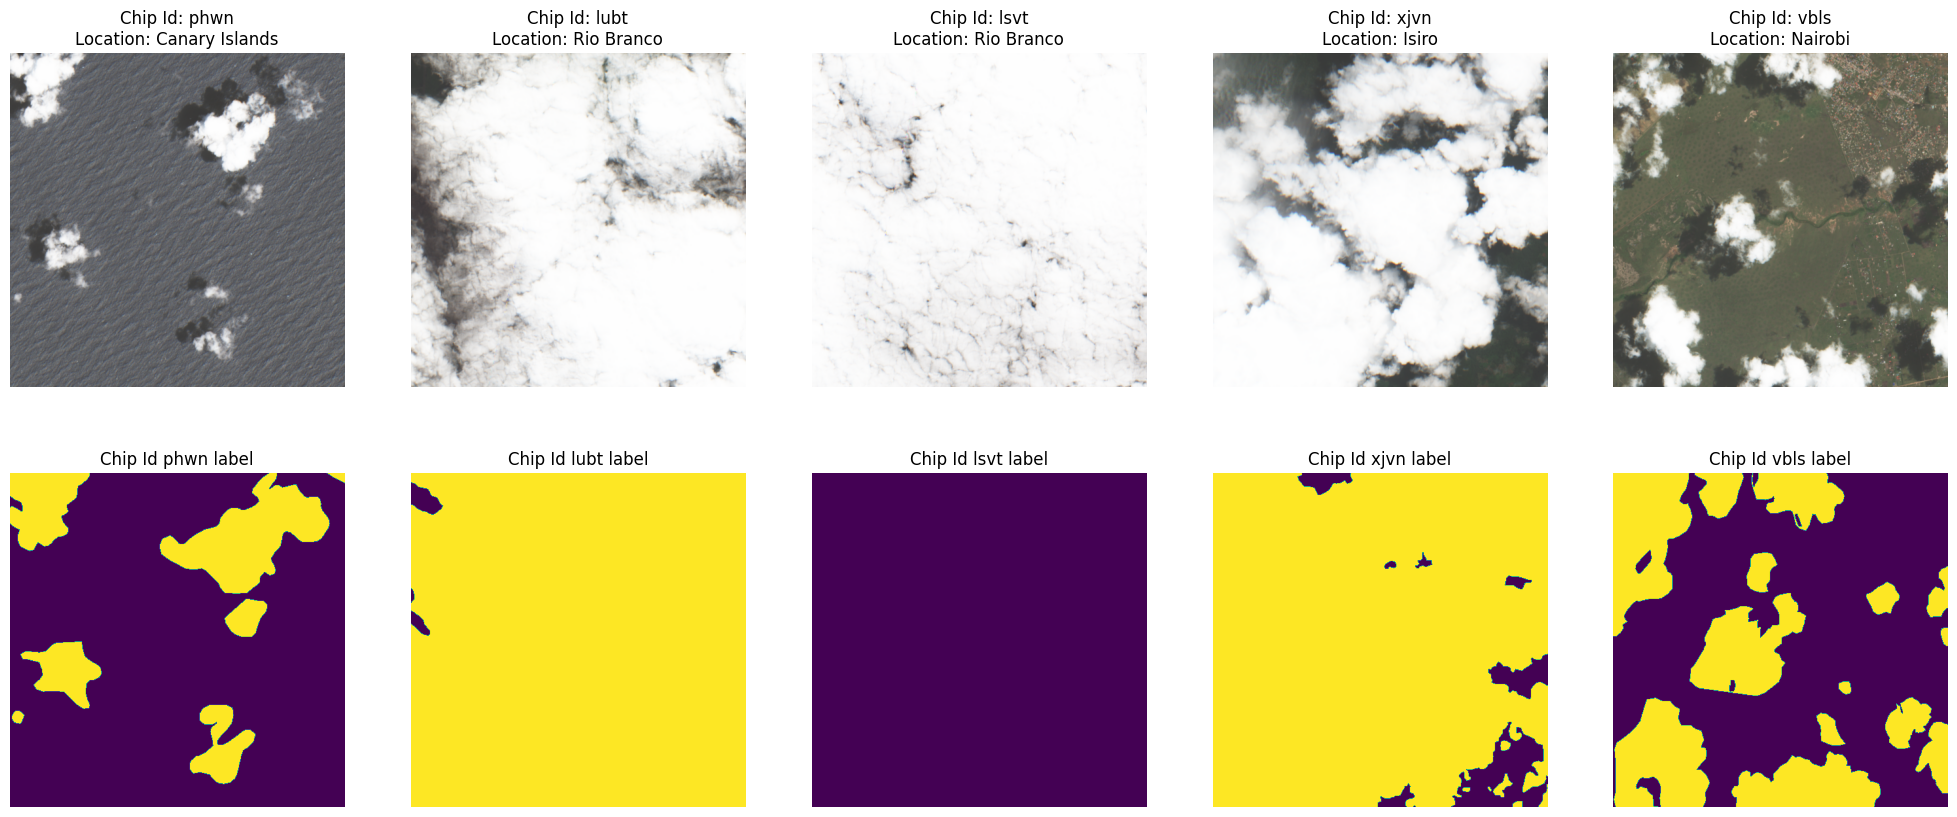

In [ ]:
# Display sample chips and the corresponding mask

fig = plt.figure(figsize=(25, 10))
no_of_chips = 5
for i in range(1, no_of_chips+1):
    sample_chip = meta_data.sample().iloc[0]
    ax = fig.add_subplot(2, no_of_chips, i)
    ax.axis("off")
    ax.imshow(true_color_img(sample_chip.chip_id))
    ax.set_title(f"Chip Id: {sample_chip.chip_id}\nLocation: {sample_chip.location}")

    ax = fig.add_subplot(2, 5, i+no_of_chips)
    ax.axis("off")
    label = Image.open(sample_chip.label_path)
    ax.imshow(label)
    ax.set_title(f"Chip Id {sample_chip.chip_id} label")

# Preparation for model fine-tuning
The first step is to divide dataset into train, validation and test set.
We will assign 30% of the data set as test data. From remaining 70%, 30% shall be validation data and rest all shall be training data.

In [ ]:
print(f"Total numbers of chips= {meta_data['chip_id'].count()}")
no_of_test_data = round(meta_data['chip_id'].count() * 0.3)
print(f"Number of chips in Test dataset = {no_of_test_data}")
no_of_validation_data = round(meta_data['chip_id'].count() * 0.7 * 0.3)
print(f"Number of chips in Validation dataset = {no_of_validation_data}")
print(f"Number of chips in Train dataset= {meta_data['chip_id'].count()-no_of_test_data-no_of_validation_data}")

Total numbers of chips= 11748
Number of chips in Test dataset = 3524
Number of chips in Validation dataset = 2467
Number of chips in Train dataset= 5757


## Extracting the Test Data
We attempt to divide the dataset based on the locations. Random locations are selected and total number of chips contribution from those locations are counted. The number of locations are increased in each loop. As soon as we get the required number of chips, break the loop and select the corresponding locations for the test data.

Error and exception clause is used in this loop because it is possible that we don't get required number of chips as we keep on adding the locations. In such cases, we just restart from beginning.

In [ ]:
test_meta = pd.DataFrame(columns=meta_data.columns)
n_loc = 15
iters = 0
while True:
    try:
        random_locations = location_counts.sample(n=n_loc)
        no_of_chips = np.sum(random_locations.to_numpy())
        if no_of_chips in range(no_of_test_data-100, no_of_test_data+100):
            # print(f"Number of Locations in the Test Dataset: {random_locations.count()}")
            # print(f"Total number of chips in the Test Dataset: {no_of_chips}")
            # print(f"Details of the selected locations:\n{random_locations}")
            break
        n_loc+=1
    except ValueError:
        n_loc=15
        iters+=1
        if iters == 20:
            print(f"Failed after {iters} iterations....\nIncrease the range for total number of chips required in the test data")
            break
        continue

for i in random_locations.index:
    next_row = meta_data.loc[meta_data.location == i, :]
    test_meta = pd.concat([test_meta, next_row])
    meta_data.drop(next_row.index, inplace=True)
location_counts = meta_data.groupby("location")["chip_id"].nunique()

## Extracting the Validation Data
Same process is repeated for creating the validation dataset.

In [ ]:
validation_meta = pd.DataFrame(columns=meta_data.columns)
n_loc = 10
iters = 0
while True:
    try:
        random_locations = location_counts.sample(n=n_loc)
        no_of_chips = np.sum(random_locations.to_numpy())
        if no_of_chips in range(no_of_validation_data-100, no_of_validation_data+100):
            # print(f"Number of Locations in the Validation Dataset: {random_locations.count()}")
            # print(f"Total number of chips in the Validation Dataset: {no_of_chips}")
            # print(f"Details of the selected locations:\n{random_locations}")
            break
        n_loc+=1
    except ValueError:
        n_loc=10
        iters+=1
        if iters == 20:
            print(f"Failed after {iters} iterations....\nIncrease the range for total number of chips required in the test data")
            break
        continue

for i in random_locations.index:
    next_row = meta_data.loc[meta_data.location == i, :]
    validation_meta = pd.concat([validation_meta, next_row])
    meta_data.drop(next_row.index, inplace=True)
location_counts = meta_data.groupby("location")["chip_id"].nunique()

## The Training Data

In [ ]:
# print(f"Number of Locations in the Training Dataset: {location_counts.count()}")
# print(f"Total number of chips in the Training Dataset: {np.sum(location_counts.to_numpy())}")
# print(f"Details of the selected locations:\n{location_counts}")

Summary of number of data points in each dataset after the train-validate-test split

In [ ]:
total = len(meta_data)+len(validation_meta)+len(test_meta)
print(f"Training data: {len(meta_data)}({round(len(meta_data)*100/total, 2)}%)")
print(f"Validation data: {len(validation_meta)}({round(len(validation_meta)*100/total, 2)}%)")
print(f"Test data: {len(test_meta)}({round(len(test_meta)*100/total, 2)}%)")

Training data: 5830(49.63%)
Validation data: 2494(21.23%)
Test data: 3424(29.15%)


## Creating Dataset
Create custom Dataset by importing PyTorch Dataset class for further processing.

In [ ]:
class CloudDataset(Dataset):
  def __init__(self, data_df: pd.DataFrame,
               bands: List[str]=bands):
    '''
    Construct Dataset type class
    '''
    self.data = data_df
    self.bands = bands
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx: int):
    img = self.data.loc[idx]
    band_stack = []
    for band in self.bands:
      with rasterio.open(img[f"{band}_path"]) as b:
        next_band = b.read(1).astype("float32")
      band_stack.append(next_band)

    feature_array = np.stack(band_stack, axis = -1)
    feature_array = np.transpose(feature_array, [2, 0, 1])

    l_path = self.data.loc[idx].label_path
    with rasterio.open(l_path) as l:
      label_array = l.read(1).astype("float32")

    item = {"chip_id": img.chip_id,
            "image": feature_array,
            "label": label_array}
    return item

## Modify the pre-trained model
Update the number of input channels from 3 to 4 - consistent with the available dataset

In [ ]:
def modifiedSegformer():
  n_channels = 4

  # Get pretrained model
  segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

  # Copy the configuration of pretrained model
  new_config = segformer_model.config

  # Modify config's values
  new_config.num_channels=n_channels

  # Instantiate new (randomly initialized) model
  new_model = SegformerForSemanticSegmentation(new_config)

  #Substitute first layer of the pretrained model with the modified one
  segformer_model.segformer.encoder.patch_embeddings[0] = new_model.segformer.encoder.patch_embeddings[0]

  return segformer_model.to(device)

## Training and Evaluation functions

In [ ]:
def training(model, n_epochs=10, mode='Validation'):
  model.train()

  since = time.time()
  print("\n\n*************Model Training*************\n\n")
  for epoch in range(1, n_epochs+1):

    print(f"-----------Epoch: {epoch}-----------")
    for idx, batch in enumerate(trainDataloader):
      x = batch["image"].to(device)
      y = batch["label"].long().to(device)

      # Computationally efficient operation compared to 'optimizer.zero_grad()'
      # as per 'https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html'
      optimizer.zero_grad(set_to_none=True)

      with torch.autocast(device_type=device, dtype=autocastType, enabled=ifcuda):
        outputs = model(x, y)
        loss, logits = outputs[0], outputs[1]
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      # optimizer.step()

      with torch.no_grad():
        upsampled_logits = nn.functional.interpolate(
                        logits,
                        size=y.shape[-2:],
                        mode="bilinear",
                        align_corners=False
                    )

        predicted = upsampled_logits.argmax(dim=1)

        predictions=predicted.detach().cpu().numpy()
        references=y.detach().cpu().numpy()

        train_mean_iou.add_batch(
          predictions=predictions,
          references=references
        )

      # if idx % 10 == 0:
        metrics = train_mean_iou.compute(
            num_labels=2,
            ignore_index=255
        )

      print(f"Batch Number: {idx}")
      print(f'loss: {loss.item()}\t\tMean IOU: {metrics["mean_iou"]}\t\tMean Accuracy: {metrics["mean_accuracy"]}')

    if epoch % 2 == 0 and mode == 'Validation':
      evaluation(model, evalDataloader = valDataloader, mode = mode)
  print(f"\n\nTraining time: {time.time()-since}s")
  print("\n\n*************Training Complete*************\n\n")
  return model

def evaluation(model, evalDataloader, mode = "Test"):
  global best_acc
  model.eval()

  print("\n\n*************Model Evaluation*************\n\n")
  with torch.no_grad():
    total_loss = 0
    for idx, batch in enumerate(evalDataloader):
      x = batch["image"].to(device)
      y = batch["label"].long().to(device)

      outputs = model(x, y)
      loss, logits = outputs[0], outputs[1]

      total_loss += loss.item()
      upsampled_logits = nn.functional.interpolate(
                      logits,
                      size=y.shape[-2:],
                      mode="bilinear",
                      align_corners=False
                  )

      predicted = upsampled_logits.argmax(dim=1)

      predictions=predicted.detach().cpu().numpy()
      references=y.detach().cpu().numpy()

      test_mean_iou.add_batch(
        predictions=predictions,
        references=references
      )

    metrics = test_mean_iou.compute(num_labels=2, ignore_index=255)
    mean_loss = total_loss/len(testDataloader)
    print(f'{mode} loss: {mean_loss}\t\tMean IOU: {metrics["mean_iou"]}\t\tMean Accuracy: {metrics["mean_accuracy"]}')

  if mode == 'Test':
    pass
  elif best_acc < metrics["mean_accuracy"]:
    best_acc = metrics["mean_accuracy"]
  print("\n\n*************Evaluation Complete*************\n\n")


Pruning Function - Apply 50% network pruning, to increase the training speed

In [ ]:
def model_prune(model):
  parameters_to_prune = [(model.segformer.encoder.patch_embeddings[0].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[1].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[2].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[3].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[0].layer_norm, 'weight'),
  (model.segformer.encoder.patch_embeddings[1].layer_norm, 'weight'),
  (model.segformer.encoder.patch_embeddings[2].layer_norm, 'weight'),
  (model.segformer.encoder.patch_embeddings[3].layer_norm, 'weight')]

  for j in range(2):
    for k in range(3):
      parameters_to_prune += [(model.segformer.encoder.block[k][j].attention.self.sr, 'weight'),
      (model.segformer.encoder.block[k][j].attention.self.layer_norm, 'weight')]
    for i in range(4):
      parameters_to_prune += [(model.segformer.encoder.block[i][j].layer_norm_1, 'weight'),
      (model.segformer.encoder.block[i][j].attention.self.query, 'weight'),
      (model.segformer.encoder.block[i][j].attention.self.key, 'weight'),
      (model.segformer.encoder.block[i][j].attention.self.value, 'weight'),
      (model.segformer.encoder.block[i][j].attention.output.dense, 'weight'),
      (model.segformer.encoder.block[i][j].layer_norm_2, 'weight'),
      (model.segformer.encoder.block[i][j].mlp.dense1, 'weight'),
      (model.segformer.encoder.block[i][j].mlp.dwconv.dwconv, 'weight'),
      (model.segformer.encoder.block[i][j].mlp.dense2, 'weight')]

  parameters_to_prune = tuple(parameters_to_prune)

  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount = 0.5
  )
  # print(model.segformer.encoder.block[i][j].mlp.dense2._forward_pre_hooks)

Create the Dataset and Dataloder

In [ ]:
# Because of resource constraint, currently using only 200 images for training, 120 for validation and 80 for test
trainDataset = CloudDataset(data_df = meta_data.reset_index(drop=True)[0:200],
                            bands = bands)
valDataset = CloudDataset(data_df = validation_meta.reset_index(drop=True)[0:120],
                          bands = bands)
testDataset = CloudDataset(data_df = test_meta.reset_index(drop=True)[0:80],
                          bands = bands)

batch_size = 8
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=2)
valDataloader = DataLoader(valDataset, batch_size=batch_size, num_workers=2)
testDataloader = DataLoader(testDataset, batch_size=batch_size, num_workers=2)

Define model, update the available device and define the evaluation metrics.

In [ ]:
device, ifcuda, autocastType = ("cuda", True, torch.float16) if torch.cuda.is_available() else ("cpu", False, torch.bfloat16)
model = modifiedSegformer()
scaler = torch.cuda.amp.GradScaler(enabled=ifcuda)

hypr_params = {"learning_rate": 0.0001,
               "optimizer": optim.SGD
               }

n_epochs = 5
train_mean_iou = evaluate.load("mean_iou")
val_mean_iou = evaluate.load("mean_iou")
test_mean_iou = evaluate.load("mean_iou")

#Model Training

In [ ]:
best_acc = 0
print("Tuning the learning rate.....")
for hypr_params["learning_rate"] in [0.001, 0.0001]:
  print(f"learning rate = {hypr_params['learning_rate']}")
  ref_acc = best_acc
  model = modifiedSegformer()
  # optimizer = optim.SGD(model.parameters(), lr=hypr_params["learning_rate"], momentum=0.9)
  optimizer = hypr_params['optimizer'](model.parameters(), lr=hypr_params["learning_rate"], momentum=0.9)
  model_prune(model)
  trained_model = training(model, n_epochs)
  if best_acc > ref_acc:
    best_param = hypr_params["learning_rate"]

hypr_params["learning_rate"] = best_param
print(f"The best of the tested learning rate is: {best_param}")

Tuning the learning rate.....
learning rate = 0.001


*************Model Training*************


-----------Epoch: 1-----------
Batch Number: 0
loss: 4.162733554840088		Mean IOU: 0.12247157775003667		Mean Accuracy: 0.23036919674148618
Batch Number: 1
loss: 3.145669460296631		Mean IOU: 0.18799621077984804		Mean Accuracy: 0.3505772493952262
Batch Number: 2
loss: 4.556654930114746		Mean IOU: 0.059474945963704305		Mean Accuracy: 0.11161670917390112
Batch Number: 3
loss: 4.560000896453857		Mean IOU: 0.09054625439810668		Mean Accuracy: 0.15454857585144627
Batch Number: 4
loss: 2.916393280029297		Mean IOU: 0.34978327380666346		Mean Accuracy: 0.49348518921863394
Batch Number: 5
loss: 4.049993515014648		Mean IOU: 0.1425581804593662		Mean Accuracy: 0.2749117670564357
Batch Number: 6
loss: 2.7863457202911377		Mean IOU: 0.41877862964702495		Mean Accuracy: 0.5042056993600914
Batch Number: 7
loss: 1.8800954818725586		Mean IOU: 0.37892654126910663		Mean Accuracy: 0.5150078096018121
Batch Number: 8
lo

In [ ]:
# # best_acc = 0
# best_param = hypr_params["optimizer"]
# print("Tuning the Optimizer.....")
# # model = modifiedSegformer()
# for hypr_params["optimizer"] in [optim.Adam]:
#   print(f"Optimizer = {hypr_params['optimizer'].__name__}")
#   ref_acc = best_acc
#   model = modifiedSegformer()
#   optimizer = hypr_params['optimizer'](model.parameters(), lr=hypr_params["learning_rate"])
#   model_prune(model)
#   trained_model = training(model, n_epochs)

#   if best_acc > ref_acc:
#     best_param = hypr_params["optimizer"]

# hypr_params["optimizer"] = best_param
# print(f"The best of the tested optimizer is: {best_param.__name__}")

Best Model Training

In [ ]:
# Because of resource constraint, currently using only 500 images for training, 300 for validation and 200 for test
trainDataset = CloudDataset(data_df = pd.concat([meta_data.reset_index(drop=True)[0:200], validation_meta.reset_index(drop=True)[0:120]], ignore_index=True),
                            bands = bands)

batch_size = 8
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=2)

model = modifiedSegformer()
optimizer = hypr_params['optimizer'](model.parameters(), lr=hypr_params["learning_rate"])
if hypr_params['optimizer'].__name__ == 'SGD':
  optimizer.momentum = 0.9

model_prune(model)
trained_model = training(model, n_epochs, 'Train')



*************Model Training*************


-----------Epoch: 1-----------
Batch Number: 0
loss: 4.156912326812744		Mean IOU: 0.17055678372434024		Mean Accuracy: 0.2579588315899565
Batch Number: 1
loss: 3.8897111415863037		Mean IOU: 0.13855023040175946		Mean Accuracy: 0.17535738193577732
Batch Number: 2
loss: 3.3023719787597656		Mean IOU: 0.17690950376407502		Mean Accuracy: 0.3119278338335084
Batch Number: 3
loss: 3.533149003982544		Mean IOU: 0.3785453532867172		Mean Accuracy: 0.5664988441591345
Batch Number: 4
loss: 2.364621877670288		Mean IOU: 0.2956476518364531		Mean Accuracy: 0.36148657419355396
Batch Number: 5
loss: 2.778362274169922		Mean IOU: 0.37206970761247193		Mean Accuracy: 0.513337097154231
Batch Number: 6
loss: 1.473429560661316		Mean IOU: 0.626330079212283		Mean Accuracy: 0.7622030925892487
Batch Number: 7
loss: 1.9141744375228882		Mean IOU: 0.4086924786477806		Mean Accuracy: 0.5725190422926021
Batch Number: 8
loss: 1.4925382137298584		Mean IOU: 0.49103225935015515		Mean

#Model Evaluation

In [ ]:
evaluation(trained_model, evalDataloader=testDataloader)



*************Model Evaluation*************


Test loss: 1.4164432406425476		Mean IOU: 0.5770404935606226		Mean Accuracy: 0.7595690648051665


*************Evaluation Complete*************




# Quantization
Apply Eager Mode, Post-Training, Dynamic Quantization

In [ ]:
import torch.ao.quantization.quantize_fx as quantize_fx
from torch.ao.quantization import QConfigMapping
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
model_to_quantize = trained_model.to("cpu")
model_int8 = torch.ao.quantization.quantize_dynamic(
    model_to_quantize,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

Compare the size of the quantized model with the original trained model

In [ ]:
import os
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

# compare the sizes
f=print_size_of_model(model_to_quantize,"fp32")
q=print_size_of_model(model_int8,"int8")

print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 28321.546
model:  int8  	 Size (KB): 11785.906
2.40 times smaller


In [ ]:
model_to_quantize = trained_model.to("cpu")
model_to_quantize.eval()
scripted_model = torch.jit.script(model_to_quantize)
scripted_model.save("segformer_cloud_script.pt")

# Use 'x86' for server inference (the old 'fbgemm' is still available but 'x86' is the recommended default) and ``qnnpack`` for mobile inference.
backend = "qnnpack" # replaced with ``qnnpack`` causing much worse inference speed for quantized model on this notebook
model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

quantized_model = torch.quantization.quantize_dynamic(model_to_quantize, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)
scripted_quantized_model = torch.jit.script(quantized_model)
scripted_quantized_model.save("segformer_cloud_quantized_script.pt")

NotSupportedError: ignored

In [ ]:

scripted_quantized_model = torch.jit.script(model_int8)
scripted_quantized_model.save("segformer_cloud_quantized_script.pt")

optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
optimized_scripted_quantized_model.save("segformer_cloud_optimized_quantized_script.pt")

NotSupportedError: ignored

In [ ]:
optimized_scripted_quantized_model._save_for_lite_interpreter("segformer_cloud_optimized_quantized_script_lite.ptl")
ptl = torch.jit.load("segformer_cloud_optimized_quantized_script_lite.ptl")

NameError: ignored